In [1]:
import torch
import chop.passes as passes
import optuna
import torch.nn as nn
import copy
import time
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoConfig,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
    AutoModelForMaskedLM,
    BertConfig,
    BertForMaskedLM,
    AlbertConfig,
    AlbertForMaskedLM,
)
from chop import MaseGraph
from chop.tools.utils import deepsetattr
from optuna.samplers import TPESampler
from torch.utils.data import DataLoader
from tqdm import tqdm
from IPython.display import clear_output
from torch.optim import AdamW

# Check if CUDA is available
print("CUDA available:", torch.cuda.is_available())

# Get the GPU name
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


# checkpoint = "bert-base-uncased"
# tokenizer_checkpoint = "bert-base-uncased"

# checkpoint = "roberta-base"
# tokenizer_checkpoint = "roberta-base"

checkpoint = "albert/albert-base-v2"
tokenizer_checkpoint = "albert/albert-base-v2"


dataset_name = "xu-song/cc100-samples"

dataset = load_dataset(dataset_name, "en", split="train[:100%]")
# # add dummy label
# dataset = dataset.map(lambda e: {"labels": 0, "text": e["text"]})
tokenizer = AutoTokenizer.from_pretrained(tokenizer_checkpoint)

def tokenize_function(example):
    return tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=29
    )

# Tokenize
dataset = dataset.map(tokenize_function, batched=True)

# split the dataset in train and test
dataset = dataset.train_test_split(test_size=0.2)

print(dataset)
# print(dataset["train"][0])

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)

/home/mz2221/anaconda3/envs/mase/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA available: True
GPU: NVIDIA GeForce MX350
DatasetDict({
    train: Dataset({
        features: ['text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})


In [2]:
teacher_model = AutoModelForMaskedLM.from_pretrained(checkpoint)
# model.to('cuda')

mg = MaseGraph(
    teacher_model,
    hf_input_names=[
        "input_ids",
        "attention_mask",
        "labels",
    ],
)

Some weights of the model checkpoint at albert/albert-base-v2 were not used when initializing AlbertForMaskedLM: ['albert.pooler.bias', 'albert.pooler.weight']
- This IS expected if you are initializing AlbertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
print(dataset["train"]['attention_mask'][0])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]


In [4]:
print(dataset["train"]["input_ids"])

[[2, 13, 7, 1041, 674, 32, 25, 4997, 73, 26, 98, 110, 24, 107, 60, 32, 25, 59, 72, 50, 20, 3, 0, 0, 0, 0, 0, 0, 0], [2, 535, 95, 41, 825, 1294, 27, 14, 4856, 666, 15, 17, 31, 41, 1042, 20, 477, 308, 9, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 10493, 20, 14, 193, 16, 161, 15, 826, 1532, 17, 66, 19323, 15, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 5627, 12533, 2869, 15, 72, 1551, 19, 7615, 15, 1175, 34, 20, 3034, 21, 3604, 12418, 26, 14, 12710, 78, 159, 75, 7833, 71, 36, 810, 8, 3], [2, 26, 653, 676, 15, 2247, 5017, 20, 1050, 331, 16, 14, 13170, 9143, 7004, 9, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 48, 1244, 25, 21, 2606, 6712, 9, 184, 630, 21, 2606, 6712, 164, 415, 3112, 22975, 4843, 4874, 60, 98, 110, 24, 57, 2879, 677, 30, 83, 3], [2, 431, 9, 30, 208, 16, 14, 14393, 23, 3535, 26, 21, 297, 2523, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 204, 15, 17, 3687, 15, 13, 7, 19496, 15, 635, 272, 2808, 15, 95, 72, 50, 88, 20, 1327, 16188, 14, 62, 187, 7, 3, 0, 0, 0], [2, 42, 22, 1

In [ ]:
import torch

# Pass the modified dummy input to pass_args
pass_args = {
    "dummy_in": None,
    "add_value": True,
    "force_device_meta": False,
}

# Run metadata analysis passes
mg, _ = passes.init_metadata_analysis_pass(mg)
mg, _ = passes.add_common_metadata_analysis_pass(mg, pass_args=pass_args)

In [2]:
# Function to retrive the condidate states
def get_search_space():
    search_space = {
        "num_hidden_layers": [3, 4, 6, 10, 12],
        "num_attention_heads": [2, 3, 4, 6, 12],
        "hidden_size": [384, 768],
        "intermediate_size": [384, 512, 576, 768, 1024, 1536, 2048, 3072],
        "hidden_act": ['gelu', 'relu', 'silu']
    }

    return search_space

In [3]:
def trainer(train_data, teacher_model, student_model, epochs=10):
    """
    Trains a student model using knowledge distillation from a teacher model.
    
    The training process involves projecting teacher model hidden states onto a lower-dimensional
    space using a learned weight matrix W, and optimizing the student model to match these projections.
    
    Parameters:
    - train_data: Dataset containing input examples.
    - teacher_model: Pre-trained teacher model (frozen during training).
    - student_model: Student model to be trained.
    - num_hidden: Number of hidden layers considered for training.
    - epochs: Number of training epochs.
    
    Returns:
    - avg_loss: Final averaged distillation loss after training.
    """
    train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True, collate_fn=lambda x: x[0])
    
    # Projection matrix W maps teacher hidden states to student hidden states
    projection = torch.nn.Linear(student_model.config.hidden_size, teacher_model.config.hidden_size).to('cuda')

    # Jointly optimize student model and projection matrix W
    optimizer = AdamW(list(student_model.parameters()) + list(projection.parameters()), lr=5e-5)
    
    # Move models to GPU for faster computation
    student_model.to('cuda')
    teacher_model.to('cuda')
    
    for epoch in range(epochs):
        student_model.train()  # Set student model to training mode
        
        running_loss = 0.0  # Track cumulative loss per epoch
        
        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            # Convert batch data to tensors and move to GPU
            input_ids = torch.tensor([batch["input_ids"][:2400]]).to('cuda')
            attention_mask = torch.tensor([batch["attention_mask"][:2400]]).to('cuda')
            
            # Forward pass through the teacher model (frozen, no gradient calculation)
            with torch.no_grad():
                outputs_teacher = teacher_model(input_ids, attention_mask, output_hidden_states=True)
            
            # Forward pass through the student model
            outputs_student = student_model(input_ids, attention_mask, output_hidden_states=True)
            
            H_teacher = outputs_teacher.hidden_states  # Tuple of teacher hidden states
            H_student = outputs_student.hidden_states  # Tuple of student hidden states
            
            Ht = []
            Hs = []  # Stores student hidden states

            # Collect student hidden states
            for i in range(len(H_student) - 1):
                H = H_student[i][0]
                Hs.append(H)
                
            # Stack student hidden states into a single tensor
            Hs = torch.stack(Hs)
            num_Hs = Hs.shape[0]
            num_Ht = len(H_teacher) - 1
            # print(f'Hs shape: {Hs.shape}')

            # Project teacher hidden states into the student space using W
            Y = projection(Hs)  # Matrix multiplication
            # print(f'Y shape: {Y.shape}')  # Expected shape: (num_hidden, sequence_length, hidden_dim)

            # For every two consecutive hidden layers in the teacher model, concatenate them
            for i in range(num_Hs):
                H0 = H_teacher[int(i * num_Ht / num_Hs)] # uniform sampled teacher hidden states with skip=2
                H1 = H_teacher[i + num_Ht - num_Hs]  # the last Ls states from the teacher hidden states
                H = torch.concatenate([H0, H1])  # Concatenation to match student dimensions
                Ht.append(H)  # Transpose for consistency
                
                if i >= len(H_student) - 1:
                    break  # Stop after reaching num_hidden layers
            
            # Stack concatenated teacher hidden layers into a single tensor
            Ht = torch.stack(Ht)
            # print(f'Ht shape: {Ht.shape}')
            
            # Compute distillation loss (Mean Squared Error between student and projected teacher outputs)
            loss = torch.nn.functional.mse_loss(Y[:, None, ...], Ht)
            
            # clear_output()  # Clear previous outputs in interactive environments
            
            # Backpropagation: Compute gradients and update weights
            optimizer.zero_grad()  # Reset gradients
            loss.backward()  # Compute gradients
            optimizer.step()  # Update model parameters
            
            # Debugging: Check gradient values
            # print(f"W gradients:\n{W.grad}")
            # for name, param in student_model.named_parameters():
            #     if param.grad is not None:
            #         print(f"{name} gradient:\n{param.grad}")
            
            running_loss += loss.item()  # Accumulate loss
        
        # Compute average loss for the epoch
        avg_loss = running_loss / len(train_dataloader)
        print(f"Epoch {epoch+1} | Avg Distillation Loss: {avg_loss:.4f}")

    return avg_loss  # Return the final average loss

In [4]:
def construct_student_model(trial):
    search_space = get_search_space()
    config = copy.deepcopy(search_space)
    
    # Assign the candidate states to the config for the student models
    for param in search_space.keys():
        param_idx = trial.suggest_int(param, 0, len(search_space[param])-1)
        config[param] = config[param][param_idx]

    new_config = AlbertConfig(**config)
    trial_model = BertForMaskedLM(new_config) # Initialize an untrained bert model using the config

    return trial_model

In [ ]:
def objective(trial):
    # Create model with this config
    checkpoint = "albert/albert-base-v2"
    teacher_model = AutoModelForMaskedLM.from_pretrained(checkpoint)
    student_model = construct_student_model(trial)
    student_model.to('cuda')

    train_data = dataset["train"]
    test_data = dataset["test"]

    test_input_ids = torch.tensor(test_data["input_ids"][:4]).to('cuda')
    test_attention_mask = torch.tensor(test_data["attention_mask"][:4]).to('cuda')

    start = time.time()
    loss = trainer(train_data, teacher_model, student_model, epochs=1)
    training_time = time.time() - start

    start = time.time()
    out = student_model(test_input_ids, test_attention_mask)
    inference_time = time.time() - start

    print(f"Average loss: {loss}")
    print(f"Training time: {training_time}")
    print(f"Inference time: {inference_time}")

    trial.set_user_attr("student_model", student_model)

    reward = 1 / (loss + inference_time * 100)

    return reward

In [ ]:
sampler = TPESampler()
study = optuna.create_study(direction="maximize", sampler=sampler)  # Minimize loss
study.optimize(objective, n_trials=20)

**Reinforcement learning method**

In [4]:
class LightLSTM(nn.Module):
    def __init__(self, hidden_dim, num_layers, dropout=0.2):
        super(LightLSTM, self).__init__()

        self.lstm = nn.LSTM(
            input_size=5,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=False
        )
        self.fc = nn.Linear(hidden_dim, 1)  # Bidirectional
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = self.dropout(lstm_out)  # Last time step
        x = self.fc(x)

        return x.squeeze(1)
    
def trainLSTM(model, input, label, lr, epochs=1):
    loss_fn = nn.MSELoss()
    optimizer = AdamW(model.parameters(), lr=lr)
    input = input.unsqueeze(0) 
    print(input.shape)

    for _ in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(input)
        print(output.shape)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()

In [5]:
Q_table = np.zeros([5, 5, 2, 8, 3])

In [276]:
indices = np.indices(Q_table.shape)
index_combinations = torch.tensor(indices.reshape(len(Q_table.shape), -1).T, dtype=torch.float32)
print(index_combinations)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 2.],
        ...,
        [4., 4., 1., 7., 0.],
        [4., 4., 1., 7., 1.],
        [4., 4., 1., 7., 2.]])


In [325]:
Q_table[(1, 1, 1, 1, 1)] = 1
Q_table[(1, 1, 0, 1, 1)] = 2
non_zeros_idx = np.nonzero(Q_table)
non_zeros_idx = torch.tensor(list(zip(*non_zeros_idx)), dtype=torch.float32, requires_grad=True).to('cuda')
non_zeros = torch.tensor(Q_table[Q_table != 0], dtype=torch.float32).to('cuda')
print(non_zeros_idx)
print(non_zeros)

tensor([[1., 1., 0., 1., 1.],
        [1., 1., 1., 1., 1.]], device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor([2., 1.], device='cuda:0')


In [322]:
lstm = LightLSTM(16, 2)
out = lstm(index_combinations)
selected = index_combinations[torch.argmax(out).item()]
print(selected)
# trainLSTM(lstm, non_zeros_idx, non_zeros, 1, 1e-3)

tensor([3., 0., 1., 7., 1.])


In [8]:
episodes = 10
e = 1
beta = 1.0
alpha = -1.0
best_model = None
best_reward = 0
best_config = None
prev_best_reward = 0
prev_best_config = None

In [9]:
lstm = LightLSTM(16, 4).to('cuda')
for _ in range(episodes):
    rewards = []
    best_episode_reward = 0
    best_episode_config = None
    for i in range(2):
        # Create model with this config
        checkpoint = "albert/albert-base-v2"
        teacher_model = AutoModelForMaskedLM.from_pretrained(checkpoint)

        search_space = get_search_space()
        config = {key: None for key in search_space}
        
        idxs = []
        # Assign the candidate states to the config for the student models
        explore = np.random.choice([True, False], p=[e, 1-e])
        if explore:
            print("Chosen to explore this step.")
            idx = []
            for key in search_space.keys():
                param_idx = np.random.choice(range(len(search_space[key])))
                config[key] = search_space[key][param_idx]
                idx.append(param_idx)
        else:
            print("Chosen to exploit this step.")
            indices = np.indices([5, 5, 2, 8, 3])
            index_combinations = torch.tensor(indices.reshape(len([5, 5, 2, 8, 3]), -1).T, dtype=torch.float32).to('cuda')
            predicts = lstm(index_combinations)
            idx = index_combinations[torch.argmax(predicts).item()].cpu()

            for i, (key, value) in enumerate(config.items()):
                config[key] = search_space[key][int(idx[i])]

        chosen_config = np.array(idx)
        idxs.append(chosen_config)

        if isinstance(config["hidden_size"], list):  # Ensure it's not a list
            config["hidden_size"] = int(config["hidden_size"][0])

        new_config = AlbertConfig(**config)
        student_model = BertForMaskedLM(new_config) # Initialize an untrained bert model using the config

        # print("model:")
        # print(student_model.bert.encoder.layer[0].intermediate.dense.weight)

        student_model.to('cuda')
        teacher_model.to('cuda')

        train_data = dataset["train"]
        test_data = dataset["test"]

        test_input_ids = torch.tensor(test_data["input_ids"][:4]).to('cuda')
        test_attention_mask = torch.tensor(test_data["attention_mask"][:4]).to('cuda')

        start = time.time()
        loss = trainer(train_data, teacher_model, student_model, epochs=1)
        training_time = time.time() - start

        # print("model:")
        # print(student_model.bert.encoder.layer[0].intermediate.dense.weight)

        start = time.time()
        out = student_model(test_input_ids, test_attention_mask)
        Ls = time.time() - start

        start = time.time()
        out = teacher_model(test_input_ids, test_attention_mask)
        Lt = time.time() - start

        print(f"Average loss: {loss}")
        print(f"Training time: {training_time}")
        print(f"Inference time: {Ls}")

        reward = (1 - loss) * (Ls / (beta * Lt)) ** alpha
        print(f'Reward: {reward}')
        rewards.append(reward)

        if reward > best_reward:
            best_model = student_model
            best_reward = reward
            best_config = chosen_config
        if reward > best_episode_reward:
            best_episode_reward = reward
            best_episode_config = chosen_config

        e *= 0.95
    
    idxs.append(best_config)
    rewards.append(best_reward)
    if prev_best_config is not None:
        idxs.append(prev_best_config)
        rewards.append(prev_best_reward)
    input = torch.tensor(idxs, dtype=torch.float32).to('cuda')
    print(f'LSTM input: {input}')
    labels = torch.tensor(rewards, dtype=torch.float32).to('cuda')
    print("Training LSTM...")
    trainLSTM(lstm, input, labels, lr=1e-3)

    prev_best_config = best_episode_config
    prev_best_reward = best_episode_reward


Some weights of the model checkpoint at albert/albert-base-v2 were not used when initializing AlbertForMaskedLM: ['albert.pooler.bias', 'albert.pooler.weight']
- This IS expected if you are initializing AlbertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Chosen to explore this step.


Epoch 1/1:   0%|          | 0/63 [00:00<?, ?it/s]/tmp/ipykernel_1208/836544344.py:83: UserWarning: Using a target size (torch.Size([6, 2, 29, 768])) that is different to the input size (torch.Size([6, 1, 29, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(Y[:, None, ...], Ht)
Epoch 1/1: 100%|██████████| 63/63 [00:14<00:00,  4.26it/s]


Epoch 1 | Avg Distillation Loss: 0.8657
Average loss: 0.8656780691373915
Training time: 14.786269664764404
Inference time: 0.008085489273071289
Reward: 1.3570186660148538


Some weights of the model checkpoint at albert/albert-base-v2 were not used when initializing AlbertForMaskedLM: ['albert.pooler.bias', 'albert.pooler.weight']
- This IS expected if you are initializing AlbertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Chosen to explore this step.


Epoch 1/1:   0%|          | 0/63 [00:00<?, ?it/s]/tmp/ipykernel_1208/836544344.py:83: UserWarning: Using a target size (torch.Size([10, 2, 29, 768])) that is different to the input size (torch.Size([10, 1, 29, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(Y[:, None, ...], Ht)
Epoch 1/1: 100%|██████████| 63/63 [00:16<00:00,  3.78it/s]
/tmp/ipykernel_1208/1196935618.py:93: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  input = torch.tensor(idxs, dtype=torch.float32).to('cuda')


Epoch 1 | Avg Distillation Loss: 0.8038
Average loss: 0.8038382416679746
Training time: 16.675267934799194
Inference time: 0.017983436584472656
Reward: 1.0487871577979118
LSTM input: tensor([[3., 2., 0., 5., 2.],
        [2., 4., 0., 6., 0.]], device='cuda:0')
Training LSTM...
torch.Size([1, 2, 5])
torch.Size([1, 2, 1])


/home/mz2221/anaconda3/envs/mase/lib/python3.11/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([1, 2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Some weights of the model checkpoint at albert/albert-base-v2 were not used when initializing AlbertForMaskedLM: ['albert.pooler.bias', 'albert.pooler.weight']
- This IS expected if you are initializing AlbertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Chosen to explore this step.


Epoch 1/1:   0%|          | 0/63 [00:00<?, ?it/s]/tmp/ipykernel_1208/836544344.py:83: UserWarning: Using a target size (torch.Size([4, 2, 29, 768])) that is different to the input size (torch.Size([4, 1, 29, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(Y[:, None, ...], Ht)
Epoch 1/1: 100%|██████████| 63/63 [00:16<00:00,  3.73it/s]


Epoch 1 | Avg Distillation Loss: 0.8207
Average loss: 0.8207017135998559
Training time: 16.890212297439575
Inference time: 0.008383512496948242
Reward: 2.2424549042027864


Some weights of the model checkpoint at albert/albert-base-v2 were not used when initializing AlbertForMaskedLM: ['albert.pooler.bias', 'albert.pooler.weight']
- This IS expected if you are initializing AlbertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Chosen to explore this step.


Epoch 1/1:   0%|          | 0/63 [00:00<?, ?it/s]/tmp/ipykernel_1208/836544344.py:83: UserWarning: Using a target size (torch.Size([12, 2, 29, 768])) that is different to the input size (torch.Size([12, 1, 29, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(Y[:, None, ...], Ht)
Epoch 1/1: 100%|██████████| 63/63 [00:15<00:00,  4.06it/s]


Epoch 1 | Avg Distillation Loss: 0.8025
Average loss: 0.8024689451096549
Training time: 15.538851499557495
Inference time: 0.01247406005859375
Reward: 1.4311374105888506


/home/mz2221/anaconda3/envs/mase/lib/python3.11/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([1, 3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Some weights of the model checkpoint at albert/albert-base-v2 were not used when initializing AlbertForMaskedLM: ['albert.pooler.bias', 'albert.pooler.weight']
- This IS expected if you are initializing AlbertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


LSTM input: tensor([[4., 3., 0., 1., 1.],
        [1., 3., 1., 4., 2.],
        [2., 4., 0., 6., 0.]], device='cuda:0')
Training LSTM...
torch.Size([1, 3, 5])
torch.Size([1, 3, 1])
Chosen to explore this step.


Epoch 1/1:   0%|          | 0/63 [00:00<?, ?it/s]/tmp/ipykernel_1208/836544344.py:83: UserWarning: Using a target size (torch.Size([3, 2, 29, 768])) that is different to the input size (torch.Size([3, 1, 29, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(Y[:, None, ...], Ht)
Epoch 1/1: 100%|██████████| 63/63 [00:15<00:00,  3.99it/s]


Epoch 1 | Avg Distillation Loss: 0.9174
Average loss: 0.9174033450701881
Training time: 15.80313754081726
Inference time: 0.00647735595703125
Reward: 1.0690016124271378


Some weights of the model checkpoint at albert/albert-base-v2 were not used when initializing AlbertForMaskedLM: ['albert.pooler.bias', 'albert.pooler.weight']
- This IS expected if you are initializing AlbertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Chosen to exploit this step.


Epoch 1/1: 100%|██████████| 63/63 [00:33<00:00,  1.89it/s]


Epoch 1 | Avg Distillation Loss: 0.7512
Average loss: 0.7511873514879317
Training time: 33.297106981277466
Inference time: 0.015006065368652344
Reward: 2.7515895892315076


Some weights of the model checkpoint at albert/albert-base-v2 were not used when initializing AlbertForMaskedLM: ['albert.pooler.bias', 'albert.pooler.weight']
- This IS expected if you are initializing AlbertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


LSTM input: tensor([[4., 3., 1., 2., 0.],
        [4., 3., 1., 2., 0.],
        [1., 3., 1., 4., 2.]], device='cuda:0')
Training LSTM...
torch.Size([1, 3, 5])
torch.Size([1, 3, 1])
Chosen to explore this step.


Epoch 1/1: 100%|██████████| 63/63 [00:19<00:00,  3.18it/s]


Epoch 1 | Avg Distillation Loss: 0.7750
Average loss: 0.774994779200781
Training time: 19.853809118270874
Inference time: 0.01766657829284668
Reward: 1.8474665837116944


Some weights of the model checkpoint at albert/albert-base-v2 were not used when initializing AlbertForMaskedLM: ['albert.pooler.bias', 'albert.pooler.weight']
- This IS expected if you are initializing AlbertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Chosen to exploit this step.


Epoch 1/1: 100%|██████████| 63/63 [00:38<00:00,  1.65it/s]


Epoch 1 | Avg Distillation Loss: 0.7760
Average loss: 0.7760196252474709
Training time: 38.15046834945679
Inference time: 0.0209963321685791
Reward: 1.6934228701397056


Some weights of the model checkpoint at albert/albert-base-v2 were not used when initializing AlbertForMaskedLM: ['albert.pooler.bias', 'albert.pooler.weight']
- This IS expected if you are initializing AlbertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


LSTM input: tensor([[4., 0., 1., 1., 2.],
        [4., 3., 1., 2., 0.],
        [4., 3., 1., 2., 0.]], device='cuda:0')
Training LSTM...
torch.Size([1, 3, 5])
torch.Size([1, 3, 1])
Chosen to exploit this step.


Epoch 1/1: 100%|██████████| 63/63 [00:31<00:00,  2.01it/s]


Epoch 1 | Avg Distillation Loss: 0.7979
Average loss: 0.7979399372660925
Training time: 31.410508155822754
Inference time: 0.012237310409545898
Reward: 2.4062772163853507


Some weights of the model checkpoint at albert/albert-base-v2 were not used when initializing AlbertForMaskedLM: ['albert.pooler.bias', 'albert.pooler.weight']
- This IS expected if you are initializing AlbertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Chosen to exploit this step.


Epoch 1/1: 100%|██████████| 63/63 [00:21<00:00,  2.99it/s]


Epoch 1 | Avg Distillation Loss: 0.8436
Average loss: 0.8435882367785015
Training time: 21.11519980430603
Inference time: 0.00858163833618164
Reward: 2.203070592168386
LSTM input: tensor([[1., 3., 1., 5., 2.],
        [4., 3., 1., 2., 0.],
        [4., 1., 0., 6., 1.]], device='cuda:0')
Training LSTM...
torch.Size([1, 3, 5])
torch.Size([1, 3, 1])


Some weights of the model checkpoint at albert/albert-base-v2 were not used when initializing AlbertForMaskedLM: ['albert.pooler.bias', 'albert.pooler.weight']
- This IS expected if you are initializing AlbertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Chosen to exploit this step.


Epoch 1/1: 100%|██████████| 63/63 [00:21<00:00,  2.91it/s]


Epoch 1 | Avg Distillation Loss: 0.8181
Average loss: 0.8180613035247439
Training time: 21.69683003425598
Inference time: 0.017136812210083008
Reward: 1.0550910457725708


Some weights of the model checkpoint at albert/albert-base-v2 were not used when initializing AlbertForMaskedLM: ['albert.pooler.bias', 'albert.pooler.weight']
- This IS expected if you are initializing AlbertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Chosen to exploit this step.


Epoch 1/1: 100%|██████████| 63/63 [00:45<00:00,  1.38it/s]


Epoch 1 | Avg Distillation Loss: 0.7728
Average loss: 0.772765232457055
Training time: 45.51361799240112
Inference time: 0.014827489852905273
Reward: 2.5126886980764547


Some weights of the model checkpoint at albert/albert-base-v2 were not used when initializing AlbertForMaskedLM: ['albert.pooler.bias', 'albert.pooler.weight']
- This IS expected if you are initializing AlbertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


LSTM input: tensor([[4., 0., 1., 0., 0.],
        [4., 3., 1., 2., 0.],
        [2., 4., 1., 6., 1.]], device='cuda:0')
Training LSTM...
torch.Size([1, 3, 5])
torch.Size([1, 3, 1])
Chosen to exploit this step.


Epoch 1/1: 100%|██████████| 63/63 [00:36<00:00,  1.73it/s]


Epoch 1 | Avg Distillation Loss: 0.7199


Some weights of the model checkpoint at albert/albert-base-v2 were not used when initializing AlbertForMaskedLM: ['albert.pooler.bias', 'albert.pooler.weight']
- This IS expected if you are initializing AlbertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Average loss: 0.7198853005492498
Training time: 36.39159798622131
Inference time: 0.016653060913085938
Reward: 3.4996130457121084
Chosen to exploit this step.


Epoch 1/1: 100%|██████████| 63/63 [00:37<00:00,  1.67it/s]


Epoch 1 | Avg Distillation Loss: 0.7940
Average loss: 0.7940181261963315
Training time: 37.65274167060852
Inference time: 0.02188730239868164
Reward: 1.12472179205322


Some weights of the model checkpoint at albert/albert-base-v2 were not used when initializing AlbertForMaskedLM: ['albert.pooler.bias', 'albert.pooler.weight']
- This IS expected if you are initializing AlbertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


LSTM input: tensor([[4., 1., 0., 6., 0.],
        [4., 2., 1., 1., 1.],
        [4., 0., 1., 0., 0.]], device='cuda:0')
Training LSTM...
torch.Size([1, 3, 5])
torch.Size([1, 3, 1])
Chosen to exploit this step.


Epoch 1/1: 100%|██████████| 63/63 [00:45<00:00,  1.38it/s]


Epoch 1 | Avg Distillation Loss: 0.7406


Some weights of the model checkpoint at albert/albert-base-v2 were not used when initializing AlbertForMaskedLM: ['albert.pooler.bias', 'albert.pooler.weight']
- This IS expected if you are initializing AlbertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Average loss: 0.7406376500924429
Training time: 45.7527277469635
Inference time: 0.03082895278930664
Reward: 1.8523168571472397
Chosen to explore this step.


Epoch 1/1: 100%|██████████| 63/63 [00:12<00:00,  4.95it/s]


Epoch 1 | Avg Distillation Loss: 1.0061
Average loss: 1.0060838640682281
Training time: 12.737013339996338
Inference time: 0.010336160659790039
Reward: -0.03147322247368962


Some weights of the model checkpoint at albert/albert-base-v2 were not used when initializing AlbertForMaskedLM: ['albert.pooler.bias', 'albert.pooler.weight']
- This IS expected if you are initializing AlbertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


LSTM input: tensor([[0., 3., 0., 0., 0.],
        [4., 2., 1., 1., 1.],
        [4., 2., 1., 1., 1.]], device='cuda:0')
Training LSTM...
torch.Size([1, 3, 5])
torch.Size([1, 3, 1])
Chosen to exploit this step.


Epoch 1/1: 100%|██████████| 63/63 [00:48<00:00,  1.31it/s]


Epoch 1 | Avg Distillation Loss: 0.7413


Some weights of the model checkpoint at albert/albert-base-v2 were not used when initializing AlbertForMaskedLM: ['albert.pooler.bias', 'albert.pooler.weight']
- This IS expected if you are initializing AlbertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Average loss: 0.7413184633330693
Training time: 48.04136657714844
Inference time: 0.01406097412109375
Reward: 4.201640649119127
Chosen to explore this step.


Epoch 1/1: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch 1 | Avg Distillation Loss: 0.8930
Average loss: 0.8930440176100958
Training time: 24.742154359817505
Inference time: 0.03572583198547363
Reward: 0.753900310801198
LSTM input: tensor([[0., 4., 1., 6., 2.],
        [4., 1., 1., 3., 2.],
        [4., 4., 1., 1., 2.]], device='cuda:0')
Training LSTM...
torch.Size([1, 3, 5])
torch.Size([1, 3, 1])


Some weights of the model checkpoint at albert/albert-base-v2 were not used when initializing AlbertForMaskedLM: ['albert.pooler.bias', 'albert.pooler.weight']
- This IS expected if you are initializing AlbertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Chosen to explore this step.


Epoch 1/1: 100%|██████████| 63/63 [00:19<00:00,  3.26it/s]


Epoch 1 | Avg Distillation Loss: 0.8427
Average loss: 0.8426792451313564
Training time: 19.410449028015137
Inference time: 0.007174491882324219
Reward: 2.436448467307849


Some weights of the model checkpoint at albert/albert-base-v2 were not used when initializing AlbertForMaskedLM: ['albert.pooler.bias', 'albert.pooler.weight']
- This IS expected if you are initializing AlbertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Chosen to explore this step.


Epoch 1/1: 100%|██████████| 63/63 [00:11<00:00,  5.71it/s]


Epoch 1 | Avg Distillation Loss: 0.9800
Average loss: 0.9800124461688693
Training time: 11.042157888412476
Inference time: 0.0063762664794921875
Reward: 0.15845502498387193
LSTM input: tensor([[0., 4., 0., 2., 1.],
        [4., 1., 1., 3., 2.],
        [4., 1., 1., 3., 2.]], device='cuda:0')
Training LSTM...
torch.Size([1, 3, 5])
torch.Size([1, 3, 1])


In [9]:
torch.save(best_model, 'best_model.pth')

In [10]:
print(rewards)

[5.773759161305635, 4.897266953247007, 7.037110213901859, 6.167290898656351, 5.208947495472974]


In [11]:
rewards = [3.3097622798728095, 1.4814817231509425, 2.6569410498642427, 3.6664226716680557, 3.92000554599694,
                    6.704176587126345, 9.236450059495892, 4.705084639128236, 4.864232630034784, 4.868273065851187,
                    2.139179430062731, 1.3648185416073315, 3.9207173030644333, 4.6102397522449285, 5.810137395088696,
                    3.838869327146019, 6.681874892078105, 0.8872366445129055, 1.7339195282229347, 2.704008749129169,
                    2.1964305383217915, 5.8514344775638225, 6.396095735097381, 4.31912710540858, 3.347306839147975,
                    15.557888786280975, 3.6870288928980264, 1.7034837371203857, 3.098738793107008, 5.547356064831373,
                    5.31776997864469, 1.891750074116724, 7.6348120079426565, 9.090333468507648, 4.261702229512139,
                    6.619604097424757, 3.5935384386184435, 3.337466893086204, 7.25551096103132, 7.32627861260651,
                    1.2316395834516993, 3.5819239221289205, 12.63990830540566, 4.234336240440603, 4.626536237586528,
                    5.773759161305635, 4.897266953247007, 7.037110213901859, 6.167290898656351, 5.208947495472974]

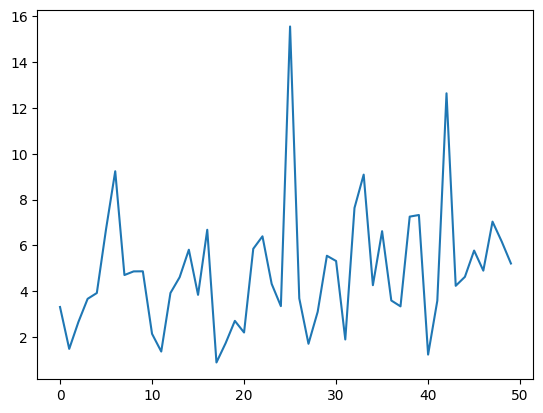

In [13]:
plt.plot(rewards)